In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import matplotlib
import h5py

import calculation.MeanFieldv2 as MFv2
import calculation.CurrentMeirv2 as CMv2
import calculation.SusceptibilitySimpv2 as Susceptv2

In [2]:
### Parameters

couplingValue = 0.7

lambdaSamples = np.array([1.0])
voltageNewSpace = np.linspace(1e-5, 1.0, 60)
TNewSpace = np.linspace(1e-5, 0.45, 60)


# voltageNewSpace = np.linspace(0.5, 1.0, 20)
# TNewSpace = np.linspace(1e-5, 0.25, 20)

## Initial Conditions
phiConstantInit = 0.5
phiLambdaInit = 0.9

In [3]:
def computeSaddlePoints(lambdaSamples, Tvalue, voltageSpacePlot, pbar=None):
    
    saddle_points = np.zeros(len(voltageSpacePlot), dtype=float)
    lambdaValue = lambdaSamples[0]
    for i in range(len(voltageSpacePlot)):
        voltageValue = voltageSpacePlot[i]
        result = scipy.optimize.root(MFv2.computeMFLambda, phiConstantInit, args=(lambdaValue, voltageValue, Tvalue, MFv2.Impy, couplingValue), method='lm', tol=1e-6)
        saddle_points[i] = result.x[0]
            
        if pbar is not None:
            pbar.update(1)
    
    return saddle_points


phi_voltage_T = np.zeros((len(TNewSpace), len(voltageNewSpace)), dtype=float)
pbar = tqdm(total=len(TNewSpace)*len(voltageNewSpace), desc='Computing phi(T)')

for i in range(len(TNewSpace)):
    Tvalue = TNewSpace[i]
    phi_voltage_T[i,:] = computeSaddlePoints(lambdaSamples, Tvalue, voltageNewSpace, pbar=pbar)
pbar.close()



Computing phi(T):   0%|          | 0/3600 [00:00<?, ?it/s]

Computing phi(T): 100%|██████████| 3600/3600 [01:06<00:00, 54.36it/s]


(60, 60)


Text(0, 0.5, 'phi')

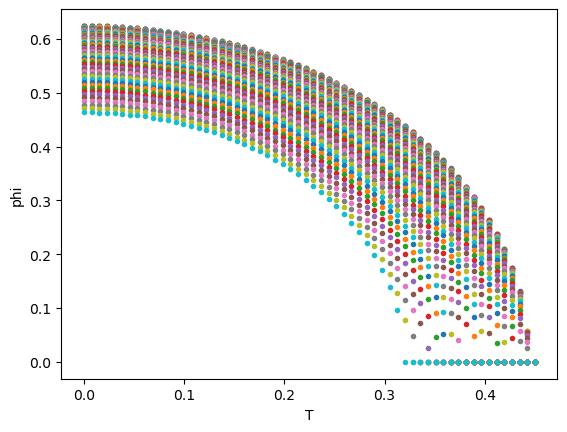

In [4]:
print(phi_voltage_T.shape)

for i in range(phi_voltage_T.shape[1]):
    plt.plot(TNewSpace, phi_voltage_T[:,i], '.')

plt.xlabel("T")
plt.ylabel("phi")

In [5]:

hstep = 1e-5
omegaSpace = np.linspace(-hstep, hstep, 2)

PiR = np.zeros((len(TNewSpace), len(voltageNewSpace), len(omegaSpace)), dtype=np.complex128)
PiK = np.zeros((len(TNewSpace), len(voltageNewSpace),len(omegaSpace)), dtype=np.complex128)
DK = np.zeros((len(TNewSpace), len(voltageNewSpace),len(omegaSpace)), dtype=np.complex128)

lambdaValue = lambdaSamples[0]
pbar = tqdm(total=len(TNewSpace)*len(voltageNewSpace), desc='Computing PiR and PiK')


for i in range(len(TNewSpace)):
   Tvalue = TNewSpace[i]
   for j in range(len(voltageNewSpace)):
      voltageValue = voltageNewSpace[j]
      phiValue = phi_voltage_T[i, j]
      
      PiR[i, j,:] = Susceptv2.computePiR(omegaSpace, lambdaValue, phiValue, voltageValue, couplingValue, Tvalue=Tvalue)
      PiK[i, j,:] = Susceptv2.computePiKnum(omegaSpace, lambdaValue, phiValue, voltageValue, couplingValue, Tvalue=Tvalue)
      
      den = 1.0 - PiR[i,j,:]/(2.0*lambdaValue)
      denReal = np.real(den)
      denImag = np.imag(den)
      DK[i,j,:] = -PiK[i,j,:]*np.reciprocal(denReal**2 + denImag**2)
      
      pbar.update(1)

pbar.close()


Computing PiR and PiK: 100%|██████████| 3600/3600 [03:59<00:00, 15.03it/s]


In [6]:

chiR = PiR/(2.0*lambdaValue**2)
chiK = PiK/(2.0*lambdaValue**2)

FauxPlus = chiR[:,:,1].imag/chiK[:,:,1].imag
FauxMinus = chiR[:,:,0].imag/chiK[:,:,0].imag

dFaux = (FauxPlus - FauxMinus)/(2*hstep)



In [25]:
def computeXK(PiKdata, PiRdata, lambdaValue):
    den = 1.0 - PiRdata/(2.0*lambdaValue)
    denReal = np.real(den)
    denImag = np.imag(den)
    return -PiKdata*np.reciprocal(denReal**2 + denImag**2)/(2.0*lambdaValue**2)




XK2 = computeXK(PiK, PiR, 1.0)


In [19]:
print(DK[:,:,1].imag)

[[ 7.44304787e-14 -4.14483087e-02 -8.29577529e-02 ... -1.74427202e+01
  -1.92213880e+01 -2.12269336e+01]
 [-7.46552744e-02 -8.89192268e-02 -1.22461201e-01 ... -1.77343435e+01
  -1.95357951e+01 -2.15672355e+01]
 [-1.50004175e-01 -1.57660930e-01 -1.79005265e-01 ... -1.80753086e+01
  -1.99054835e+01 -2.19693493e+01]
 ...
 [-9.28373640e+03 -9.34374016e+03 -9.52709443e+03 ... -5.30655818e+02
  -4.94227913e+02 -4.61058203e+02]
 [-2.52960130e+05 -2.61331773e+05 -2.89070146e+05 ... -4.63556373e+02
  -4.34297819e+02 -4.07421687e+02]
 [-1.03259898e+05 -1.02232742e+05 -9.92442350e+04 ... -4.08724147e+02
  -3.84906082e+02 -3.62859052e+02]]


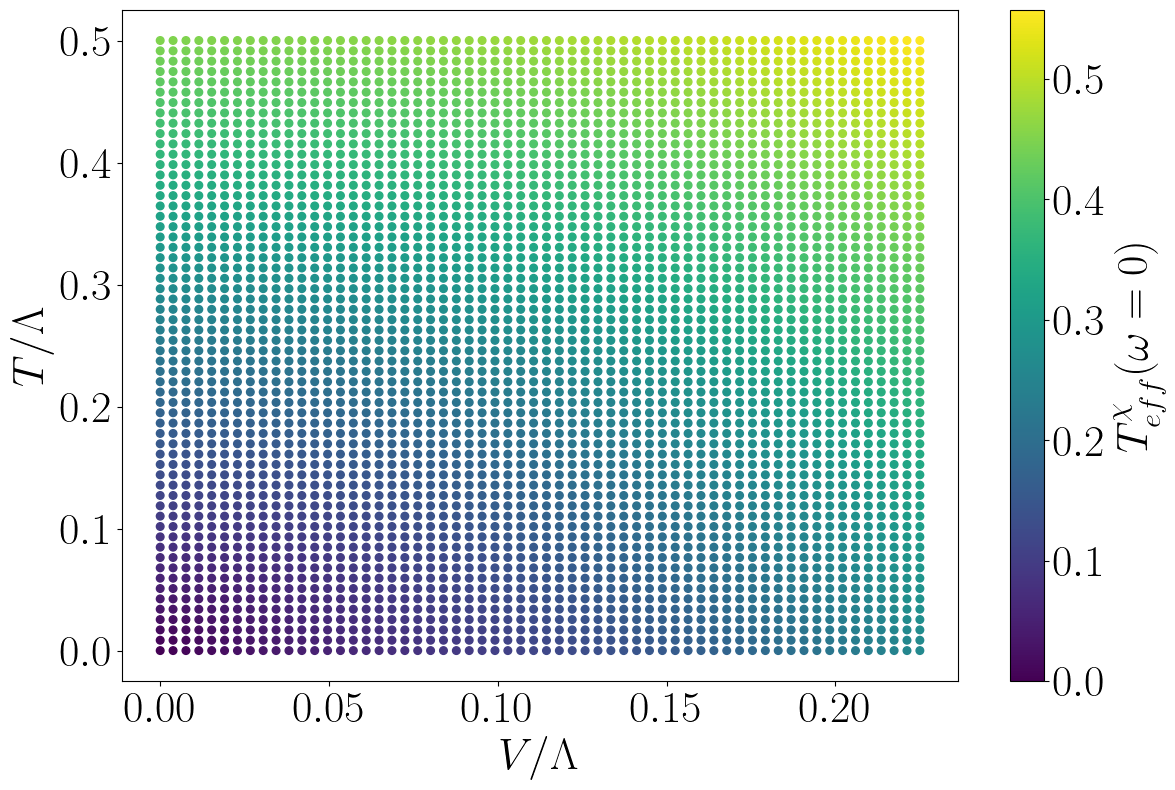

In [9]:

Xc, Yc  = np.meshgrid(TNewSpace, voltageNewSpace)

x = Xc.reshape(-1)
y = Yc.reshape(-1)
z = (0.5/dFaux).reshape(-1)

fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
sc = plt.scatter(x/2, y/2, c=z, cmap='viridis', s=30)
cbar = plt.colorbar(sc)
cbar.set_label(r'$T^{\chi}_{eff}(\omega=0)$', fontsize=32)
cbar.ax.tick_params(labelsize=32)


plt.xlabel(r'$V/\Lambda$', fontsize=32)
plt.ylabel(r'$T/\Lambda$', fontsize=32)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)

plt.tight_layout()

(3600,)
(3600,)


(-0.01, 0.3)

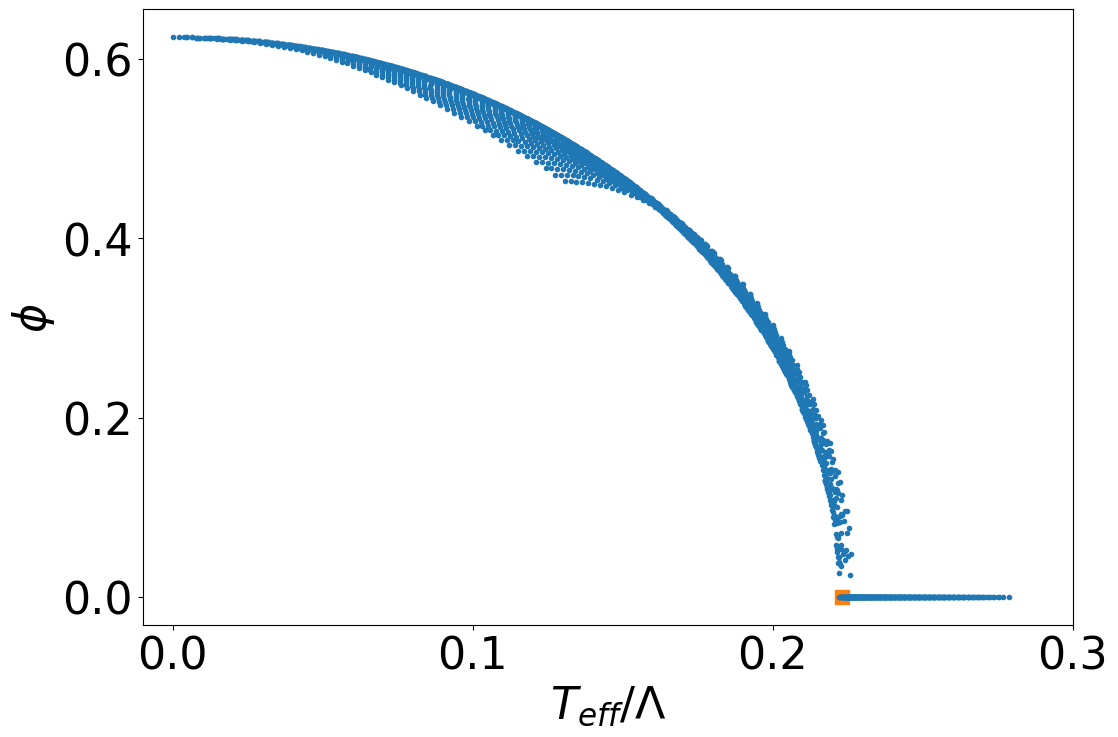

In [ ]:


dFaux_reshaped = dFaux.reshape(-1)
phi_reshaped = phi_voltage_T.reshape(-1)

print(dFaux_reshaped.shape)
print(phi_reshaped.shape)


fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
ax.plot(0.5/dFaux_reshaped/2, phi_reshaped, '.')

ax.tick_params(axis='y', labelsize=32)
ax.tick_params(axis='x', labelsize=32)

plt.ylabel(r'$\phi$', fontsize=32)
plt.xlabel(r'$T_{eff}/\Lambda$', fontsize=32)

x0 = 0.223
ax.scatter(x=x0, y=0, s=100, marker="s", color='C1', label=f'Point @ x={0.223:.1f}')


plt.xlim(-0.01, 0.3)

# plt.savefig("panels/phi_Teff.png")

(3600,)
(3600,)


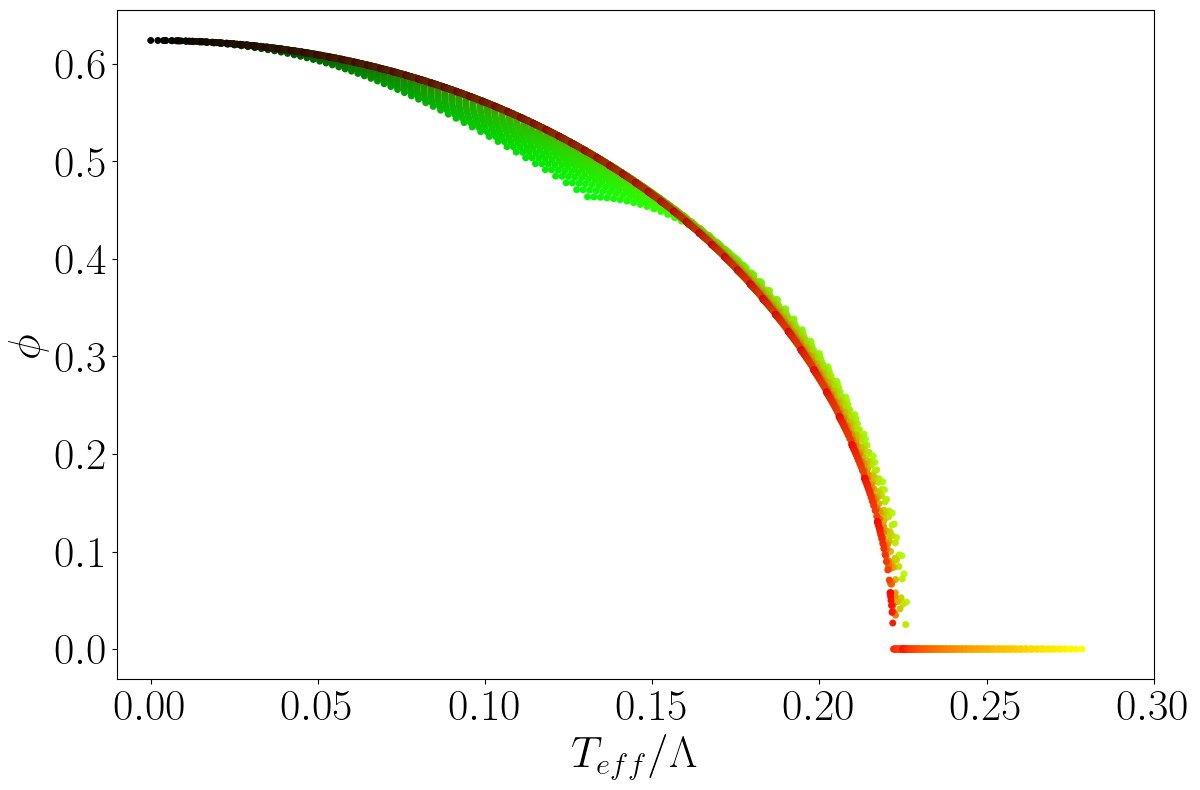

In [ ]:

dFaux_reshaped = dFaux.reshape(-1)
phi_reshaped = phi_voltage_T.reshape(-1)

print(dFaux_reshaped.shape)
print(phi_reshaped.shape)


n_points_x = 60
n_points_y = 60

x_min, x_max = 1e-5, 1.6/2
y_min, y_max = 1e-5, 0.65/2


# n_points_x = 20
# n_points_y = 20

# x_min, x_max = 1e-5, 1.6/2
# y_min, y_max = 1e-5, 0.65/2


x = np.linspace(x_min, x_max, n_points_x)
y = np.linspace(y_min, y_max, n_points_y)
X, Y = np.meshgrid(x, y)

X_flat = X.flatten()
Y_flat = Y.flatten()

R = (X_flat - x_min) / (x_max - x_min)
G = (Y_flat - y_min) / (y_max - y_min)
B = np.zeros_like(R)

# colors = np.stack((R, G, B), axis=1)
colors = np.stack((G, R, B), axis=1)

# colors = colors.reshape(-1, 3)

fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

# Use ax.scatter to set color per-point
sc = ax.scatter(
    0.5 / dFaux_reshaped / 2,  # x data
    phi_reshaped,              # y data
    c=colors,                  # color per-point
    s=100,                     # marker size (optional)
    marker='.',                # point marker (optional)
    edgecolor='none'           # no border
)

x_space = np.linspace(0.15, 0.29, 2000)
# plt.plot(x_space, 1.9*np.sqrt(0.223-x_space), linewidth=4.0)

ax.tick_params(axis='y', labelsize=32)
ax.tick_params(axis='x', labelsize=32)

plt.ylabel(r'$\phi$', fontsize=32)
plt.xlabel(r'$T_{eff}/\Lambda$', fontsize=32)

x0 = 0.223
# ax.scatter(x=x0, y=0, s=100, marker="s", color='blue')

plt.xlim(-0.01, 0.3)

plt.tight_layout()
plt.savefig("panels/phi_Teff_2.png")

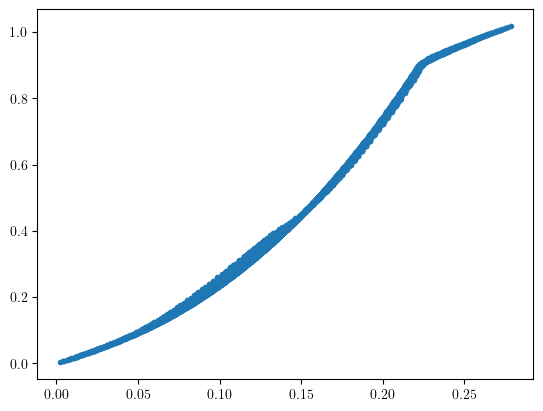

In [ ]:

Teff = 0.5 / dFaux_reshaped / 2
Fplus =  (chiK[:,:,1].imag).reshape(-1)
# Fminus = FauxMinus.reshape(-1)

plt.plot(Teff[1:], Fplus[1:], '.')
# plt.yscale('log')
# plt.plot(Teff[1:], Fminus[1:], '.')

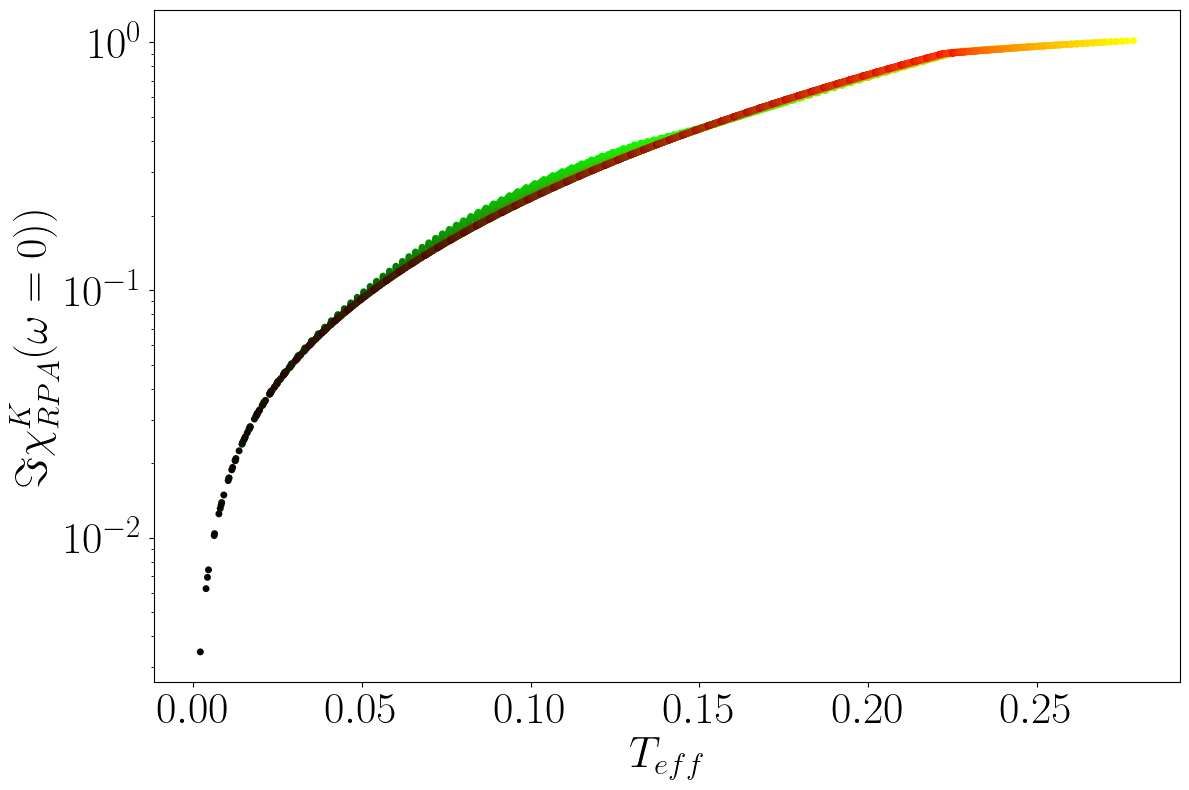

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

Teff = 0.5 / dFaux_reshaped / 2
Fplus =  (chiK[:,:,1].imag).reshape(-1)

# Use ax.scatter to set color per-point
sc = ax.scatter(
    Teff[1:],  # x data
    Fplus[1:],              # y data
    c=colors[1:],                  # color per-point
    s=100,                     # marker size (optional)
    marker='.',                # point marker (optional)
    edgecolor='none'           # no border
)

x_space = np.linspace(0.15, 0.29, 2000)
# plt.plot(x_space, 1.9*np.sqrt(0.223-x_space), linewidth=4.0)

plt.yscale('log')
ax.tick_params(axis='y', labelsize=32)
ax.tick_params(axis='x', labelsize=32)

plt.ylabel(r'$\Im \chi^K_{RPA}(\omega=0))$', fontsize=32)
plt.xlabel(r'$T_{eff}$', fontsize=32)

plt.tight_layout()
# plt.grid()
plt.savefig('panelsCurrentNoise/ImChiK_RPA_Teff.png', bbox_inches='tight', dpi=600)

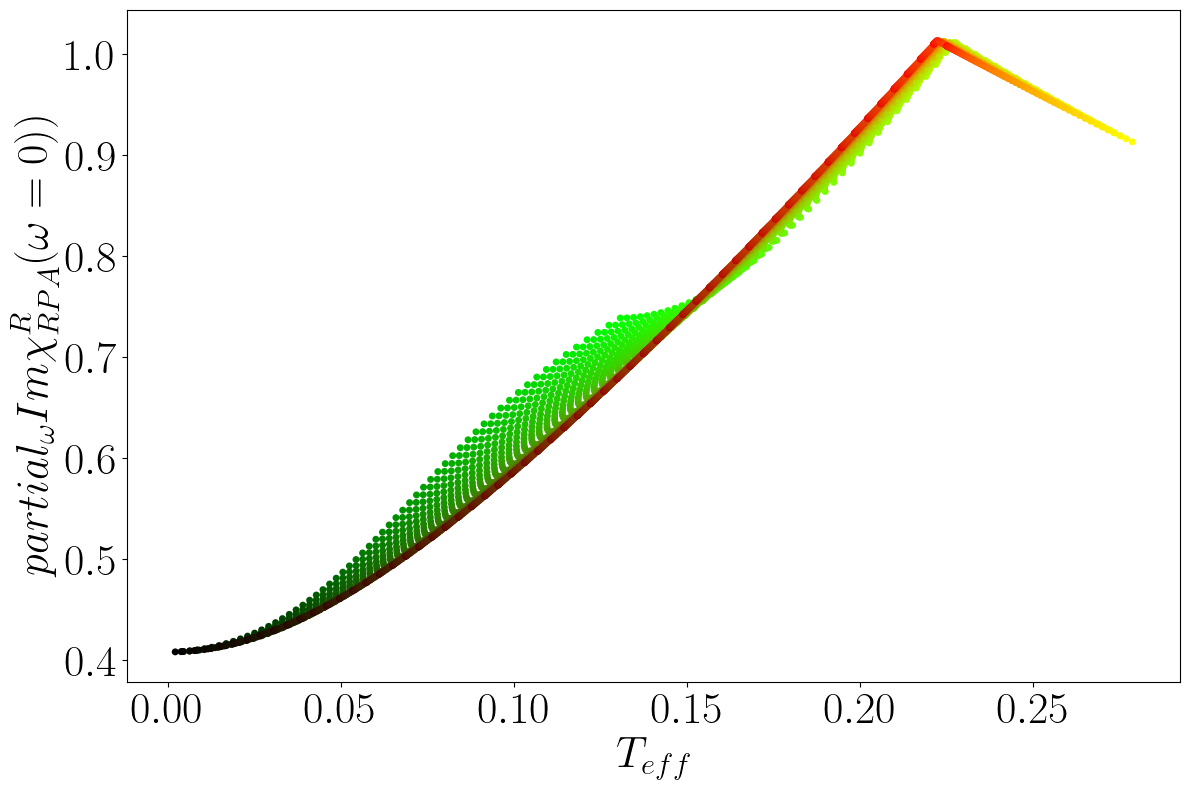

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

Teff = 0.5 / dFaux_reshaped / 2
Fplus =  ((chiR[:,:,1].imag - chiR[:,:,0].imag)/(2*hstep)).reshape(-1)

# Use ax.scatter to set color per-point
sc = ax.scatter(
    Teff[1:],  # x data
    Fplus[1:],              # y data
    c=colors[1:],                  # color per-point
    s=100,                     # marker size (optional)
    marker='.',                # point marker (optional)
    edgecolor='none'           # no border
)

x_space = np.linspace(0.15, 0.29, 2000)
# plt.plot(x_space, 1.9*np.sqrt(0.223-x_space), linewidth=4.0)

# plt.yscale('log')
ax.tick_params(axis='y', labelsize=32)
ax.tick_params(axis='x', labelsize=32)

plt.ylabel(r'$\\partial_{\omega} Im \chi^R_{RPA}(\omega=0))$', fontsize=32)
plt.xlabel(r'$T_{eff}$', fontsize=32)
plt.tight_layout()
# plt.grid()
# plt.savefig('panelsCurrentNoise/ImChiK_RPA_Teff.png', bbox_inches='tight', dpi=600)